In [82]:
#!pip install sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import pandas as pd                   # data analysis and manipulation tool
import xarray as xr                   # handling labelled multi-dimensional arrays
import intake                         # to find data in a catalog, this notebook explains how it works
from ipywidgets import widgets        # to use widgets in the Jupyer Notebook
from geopy.geocoders import Nominatim # Python client for several popular geocoding web services
import folium                         # visualization tool for maps
import hvplot.pandas
import torch
import torch.nn as nn
import torch.optim as optim

In [83]:
pb="Budapest"
eb="historical"
geolocator = Nominatim(user_agent="any_agent")
location = geolocator.geocode(pb)
parent_col=intake.open_catalog(["https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/-/raw/master/esm-collections/cloud-access/dkrz_catalog.yaml"])
col=parent_col["dkrz_cmip6_disk"]
climate_model = "MPI-ESM1-2-HR" # here we choose Max-Plack Institute's Earth Sytem Model in high resolution
query = dict(
    source_id      = climate_model, # the model 
    variable_id    = "tas", # temperature at surface, maximum
    table_id       = "day", # daily maximum
    experiment_id  = eb, # what we selected in the drop down menu,e.g. SSP2.4-5 2015-2100
    member_id      = "r10i1p1f1", # "r" realization, "i" initialization, "p" physics, "f" forcing
)
cat = col.search(**query)
del col
cat.df
dset_dict = cat.to_dataset_dict(cdf_kwargs={"chunks": {"time": -1}, "use_cftime": True})
for key, value in dset_dict.items():
    model = key.split(".")[2]  # extract model name from key
    tas_xr = value["tas"].squeeze()  # extract variable from dataset


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.source_id.experiment_id.table_id.grid_label'


In [84]:
abslat = np.abs(tas_xr["lat"] - location.latitude)
abslon = np.abs(tas_xr["lon"] - location.longitude)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))
tas_xr_filtered = tas_xr[:, yloc, xloc] - 273.15
tas_xr_filtered


<xarray.DataArray 'tas' (time: 60265)>
dask.array<sub, shape=(60265,), dtype=float32, chunksize=(1827,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    lat        float64 47.22
    lon        float64 18.75
    height     float64 ...
    member_id  <U9 'r10i1p1f1'

In [85]:
tas_xr_filtered=tas_xr_filtered.sel(time=~((tas_xr_filtered.time.dt.month==2) & (tas_xr_filtered.time.dt.day == 29)))
date_per_month = tas_xr_filtered.resample(time="M").mean("time").values
date_per_month

array([-4.096722 ,  1.6977484,  4.0374284, ...,  9.750112 ,  2.9433126,
        3.6140196], dtype=float32)

In [5]:
test_data_size=24
train_data = date_per_month[:-test_data_size]
test_data = date_per_month[-test_data_size:]

In [6]:
#Normalize temperature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [11]:
#split into train and evaluate as label
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[0]

(tensor([-0.6599, -0.3559, -0.2331,  0.1245,  0.2536,  0.5111,  0.7298,  0.6407,
          0.6118,  0.2653, -0.0854, -0.4642]),
 tensor([-0.4485]))

In [34]:
#define LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                     torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [63]:
#Train model for 150 epoches
#best till now 0.001, 50 and 32 neurons
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00107636
epoch:   1 loss: 0.00058681
epoch:   2 loss: 0.00037345
epoch:   3 loss: 0.00028876
epoch:   4 loss: 0.00023946
epoch:   5 loss: 0.00020297
epoch:   6 loss: 0.00017388
epoch:   7 loss: 0.00014958
epoch:   8 loss: 0.00013349
epoch:   9 loss: 0.00012539
epoch:  10 loss: 0.00012589
epoch:  11 loss: 0.00013009
epoch:  12 loss: 0.00013537
epoch:  13 loss: 0.00014053
epoch:  14 loss: 0.00014525
epoch:  15 loss: 0.00014979
epoch:  16 loss: 0.00015412
epoch:  17 loss: 0.00015806
epoch:  18 loss: 0.00016154
epoch:  19 loss: 0.00016459
epoch:  20 loss: 0.00016728
epoch:  21 loss: 0.00016965
epoch:  22 loss: 0.00017175
epoch:  23 loss: 0.00017360
epoch:  24 loss: 0.00017513
epoch:  25 loss: 0.00017624
epoch:  26 loss: 0.00017676
epoch:  27 loss: 0.00017666
epoch:  28 loss: 0.00017597
epoch:  29 loss: 0.00017481
epoch:  30 loss: 0.00017333
epoch:  31 loss: 0.00017169
epoch:  32 loss: 0.00017003
epoch:  33 loss: 0.00016843
epoch:  34 loss: 0.00016696
epoch:  35 loss: 0.0

In [70]:
#evaluating the model in the last 2 years
fut_pred = 24+85*12
# fut_pred = 24

test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
actual_predictions

array([[-1.10960624],
       [ 0.48960885],
       [ 4.76142035],
       ...,
       [10.6190783 ],
       [ 3.97266801],
       [-0.3816987 ]])

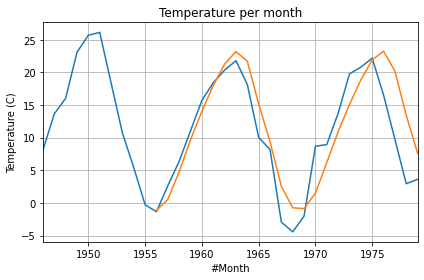

In [65]:
#plotting the differences
x = np.arange(1956, 1980, 1)
x1=np.arange(1946,1980,1)
plt.title('Temperature per month')
plt.ylabel('Temperature (C)')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x1,date_per_month[-34:])
plt.plot(x,actual_predictions)
plt.xlabel("#Month")
plt.tight_layout()
# plt.show()
plt.savefig("predict_next_2_years.png")

In [71]:
with open("lstm predicted 01-01-2015 31-12-2100.txt","w") as f:
    for d in actual_predictions:
        f.write(str(float(d))+"\n")

In [66]:
from sklearn.metrics import mean_squared_error
rmse=mean_squared_error(date_per_month[-24:],actual_predictions,squared=True)
rmse

19.702265651650418

In [92]:
#Trend analysis in the predicted data
avgResult = np.average(actual_predictions.reshape(-1, 12), axis=1)
x=np.arange(2013,2100,1)
x.shape
# avgResult.shape

(87,)

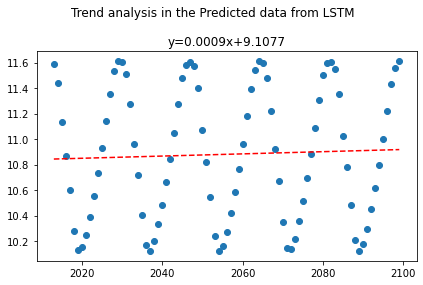

In [93]:
plt.figure()
plt.suptitle('Trend analysis in the Predicted data from LSTM')
plt.scatter(x,avgResult)
z = np.polyfit(x.flatten(), avgResult.flatten(), 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title("y=%.4fx+%.4f"%(z[0],z[1])) 
plt.tight_layout()
plt.savefig("trend_in_lstm_new.png")

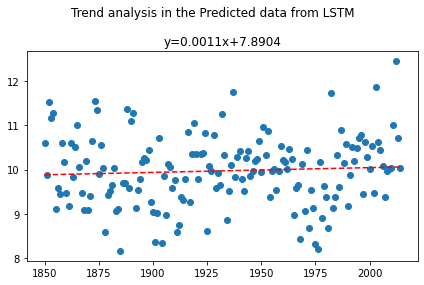

In [95]:
date_per_month_avg=np.average(date_per_month.reshape(-1, 12), axis=1)
plt.suptitle('Trend analysis in the Predicted data from LSTM')
x1=x=np.arange(1850,2015,1)
plt.scatter(x,date_per_month_avg)
z = np.polyfit(x1.flatten(), date_per_month_avg.flatten(), 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.title("y=%.4fx+%.4f"%(z[0],z[1])) 
plt.tight_layout()
plt.savefig("trend_in_lstm_old.png")